In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

import lightgbm as lgb
import xgboost as xgb

import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Mean Target Encodings Declaration

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

In [5]:
class XGBoostLeaves(BaseEstimator, ClassifierMixin):
    params = {
        'objective': 'binary:logistic',
        'eta': .1,
        'max_depth': 4,
        'silent': 1,
        'nthread': 4
    }
    
    def __init__(self, num_leaves):
        self.num_leaves = num_leaves
        
    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, y)
        self.model = xgb.train(self.params, dtrain, self.num_leaves)
        
    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X), pred_leaf=True)

## Paths

In [6]:
TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission26.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev9/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev9/val.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission26_val.feather')

In [7]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

CPU times: user 522 ms, sys: 215 ms, total: 737 ms
Wall time: 1.76 s


## Data Subset

In [9]:
train = train.loc[train.communication_type.isin(['Upcoming Events',
                                                 'Newsletter',
                                                 'Hackathon',
                                                 'Corporate'
                                                ])]

## Subject line features

In [11]:
%%time

# first keyword of the subject
train.loc[:, 'first_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'first_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')


# second keyword of the subject
train.loc[:, 'second_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[1])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'second_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[1])).str.replace(r'September|July|October|November|December', 'month')

# third keyword of the subject
train.loc[:, 'third_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[2])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'third_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[2])).str.replace(r'September|July|October|November|December', 'month')

CPU times: user 16.2 s, sys: 204 ms, total: 16.4 s
Wall time: 16.4 s


## Feature Engineering

In [12]:
%%time

# is_click

mte_click         = MeanTargetEncoding(['user_id'], target_name='is_click')
mte_click_encoded = cross_val_predict(mte_click, train, y=train.is_click, cv=5, n_jobs=-1)

user_click_mte = pd.DataFrame(mte_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# is_open

mte_open         = MeanTargetEncoding(['user_id'], target_name='is_open')
mte_open_encoded = cross_val_predict(mte_open, train, y=train.is_open, cv=5, n_jobs=-1)

user_open_mte = pd.DataFrame(mte_open_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# communication type is click
comm_type_click = MeanTargetEncoding(['communication_type'], target_name='is_click')
comm_type_click_encoded = cross_val_predict(comm_type_click, train, y=train.is_click, cv=5, n_jobs=-1)

comm_type_click_mte = pd.DataFrame(comm_type_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['comm_type']],
            index=train.index.values
            )

# generate for test

mte_click.fit(train, train.is_click)
mte_click_test_encoded = mte_click.predict(test)

mte_open.fit(train, train.is_open)
mte_open_test_encoded = mte_open.predict(test)

comm_type_click.fit(train, train.is_open)
comm_type_click_test_encoded = comm_type_click.predict(test)

user_click_test =  pd.DataFrame(mte_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

user_open_test =  pd.DataFrame(mte_open_test_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

comm_type_click_test = pd.DataFrame(comm_type_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['comm_type']],
            index=test.index.values
            )

train = pd.concat((train, user_click_mte, user_open_mte, comm_type_click_mte), axis=1)
test  = pd.concat((test, user_click_test, user_open_test, comm_type_click_test), axis=1)

CPU times: user 57.5 s, sys: 4.77 s, total: 1min 2s
Wall time: 2min 20s


In [13]:
%%time

user_id_stats = train.groupby('user_id').agg({'comm_type_click_mte_mean': [np.mean, np.std, np.max, np.min, np.median]})
user_id_stats.columns = ['comm_type_click_mean', 'comm_type_click_std',
                         'comm_type_click_max', 'comm_type_click_min',
                         'comm_type_click_median'
                        ]

train = train.merge(user_id_stats.reset_index(),
            on='user_id',
            how='left'
           ).fillna(-1)

test  = test.merge(user_id_stats.reset_index(),
            on='user_id',
            how='left'
           ).fillna(-1)

CPU times: user 3.95 s, sys: 280 ms, total: 4.23 s
Wall time: 4.32 s


In [14]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

### Other Features

In [15]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

user_age = traintest.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
traintest.loc[:, 'user_age'] = traintest.user_id.map(user_age)

CPU times: user 7min 43s, sys: 2.81 s, total: 7min 46s
Wall time: 7min 45s


### Save interim state

In [16]:
%%time

traintest.index = np.arange(len(traintest))
traintest.to_feather(f'{INTERIM_PATH}')

CPU times: user 1.09 s, sys: 421 ms, total: 1.51 s
Wall time: 2.2 s


### Load from interim state

In [28]:
%%time

traintest = pd.read_feather(f'{INTERIM_PATH}')

CPU times: user 394 ms, sys: 140 ms, total: 534 ms
Wall time: 534 ms


### Subject Line Based Features

In [17]:
%%time

# number of digits in the subject line.
digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

# whether subject line has punctuation or not.
punctuation_pattern = re.compile(r'[!.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

# interaction between open rate and click rate.
traintest.loc[:, 'click_to_open']      = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

# Number of keywords in subject.
traintest.loc[:, 'num_keywords']       = traintest.subject.map(lambda x: len(x.split(' ')))

# Number of short keywords in subject.
traintest.loc[:, 'num_short_keywords'] = traintest.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

# Ratio of short to total keywords.
traintest.loc[:, 'ratio_short_total']  = traintest.num_short_keywords / traintest.num_keywords

# Total number of characters in the subject.
traintest.loc[:, 'num_characters']     = traintest.subject.map(lambda x: len(x))

# Number of times first keyword was used in the past
traintest.loc[:, 'first_keyword_count'] = traintest.groupby('first_keyword')['first_keyword'].transform(lambda x: len(x))

# Number of times second keyword was used in the past
traintest.loc[:, 'second_keyword_count'] = traintest.groupby('second_keyword')['second_keyword'].transform(lambda x: len(x))

# Number of times third keyword was used in the past
traintest.loc[:, 'third_keyword_count'] = traintest.groupby('third_keyword')['third_keyword'].transform(lambda x: len(x))

# Label Encode First Keyword
traintest.loc[:, 'first_keyword'] = pd.factorize(traintest.first_keyword)[0]

# Label Encode Second Keyword
traintest.loc[:, 'second_keyword'] = pd.factorize(traintest.second_keyword)[0]

# Label Encode Third Keyword
traintest.loc[:, 'third_keyword'] = pd.factorize(traintest.third_keyword)[0]

CPU times: user 23.6 s, sys: 3.18 s, total: 26.8 s
Wall time: 27.9 s


** Feature Names **

In [18]:
FEATURES = ['communication_type', 
            'send_day', 
            'send_hour', 
            'send_weekday',
            'total_links', 
            'no_of_internal_links', 
            'no_of_images', 
            'no_of_sections',
            'num_emails_sent', 
            'num_diff_email_types', 
            'most_sent_type', 
            'diff_hour', 
            'avg_diff_send_date',
            'user_id_click_mte_mean', 
            'user_id_open_mte_mean',
            'user_age', 
            'subject_num_digits', 
            'subject_has_punctuation',
            'click_to_open', 
            'num_keywords', 
            'num_short_keywords',
            'ratio_short_total', 
            'num_characters',
            'first_keyword_count', 
            'second_keyword_count', 
            'third_keyword_count',
            'comm_type_click_mean', 
            'comm_type_click_std',
            'comm_type_click_max', 
            'comm_type_click_min',
            'comm_type_click_median', 
            'first_keyword', 
            'second_keyword',
            'third_keyword'
           ]

In [19]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type         0
send_day                   0
send_hour                  0
send_weekday               0
total_links                0
no_of_internal_links       0
no_of_images               0
no_of_sections             0
num_emails_sent            0
num_diff_email_types       0
most_sent_type             0
diff_hour                  0
avg_diff_send_date         0
user_id_click_mte_mean     0
user_id_open_mte_mean      0
user_age                   0
subject_num_digits         0
subject_has_punctuation    0
click_to_open              0
num_keywords               0
num_short_keywords         0
ratio_short_total          0
num_characters             0
first_keyword_count        0
second_keyword_count       0
third_keyword_count        0
comm_type_click_mean       0
comm_type_click_std        0
comm_type_click_max        0
comm_type_click_min        0
comm_type_click_median     0
first_keyword              0
second_keyword             0
third_keyword              0
dtype: int64

## Higher Order Interactions

In [20]:
%%time

num_leaves = 20

train  = traintest.iloc[:ntrain].loc[:, FEATURES]
target = traintest.iloc[:ntrain]['is_click'].values
test   = traintest.iloc[ntrain:].loc[:, FEATURES]

xgbl = XGBoostLeaves(num_leaves=num_leaves)
xgbl_encoded = cross_val_predict(xgbl, train, y=target, cv=5, n_jobs=-1)
xgbl_leaves  = pd.DataFrame(xgbl_encoded,
                            columns=['leaf_%s'%i for i in range(num_leaves)],
                            index=train.index.values
                           )

xgbl.fit(train, target)
xgbl_test_encoded = xgbl.predict(test)

xgbl_leaves_test = pd.DataFrame(xgbl_test_encoded, 
                   columns=['leaf_%s'%i for i in range(num_leaves)],
                   index=test.index.values
                   )


train = pd.concat((train, xgbl_leaves), axis=1)
test  = pd.concat((test, xgbl_leaves_test), axis=1)

CPU times: user 50.6 s, sys: 1.54 s, total: 52.1 s
Wall time: 1min 23s


In [21]:
# update feature list
FEATURES = FEATURES + list(xgbl_leaves.columns)

In [22]:
X_trn = train.loc[:, FEATURES]
y_trn = target

X_val = test.loc[:, FEATURES]
y_val = traintest.iloc[ntrain:]['is_click'].values

print(X_trn.shape, X_val.shape)

# del traintest
# gc.collect();

(636135, 54) (773858, 54)


## Validation

In [22]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.701482	eval's auc: 0.652932
[40]	train's auc: 0.711645	eval's auc: 0.679795
[60]	train's auc: 0.722645	eval's auc: 0.681902
[80]	train's auc: 0.738246	eval's auc: 0.684492
[100]	train's auc: 0.74803	eval's auc: 0.683729
[120]	train's auc: 0.756274	eval's auc: 0.685624
[140]	train's auc: 0.764667	eval's auc: 0.691593
[160]	train's auc: 0.771509	eval's auc: 0.690201
[180]	train's auc: 0.780793	eval's auc: 0.6899
[200]	train's auc: 0.788482	eval's auc: 0.684546
[220]	train's auc: 0.794761	eval's auc: 0.681978
[240]	train's auc: 0.80188	eval's auc: 0.679632
Early stopping, best iteration is:
[147]	train's auc: 0.767273	eval's auc: 0.693524


```
[147]	train's auc: 0.767273	eval's auc: 0.693524
```

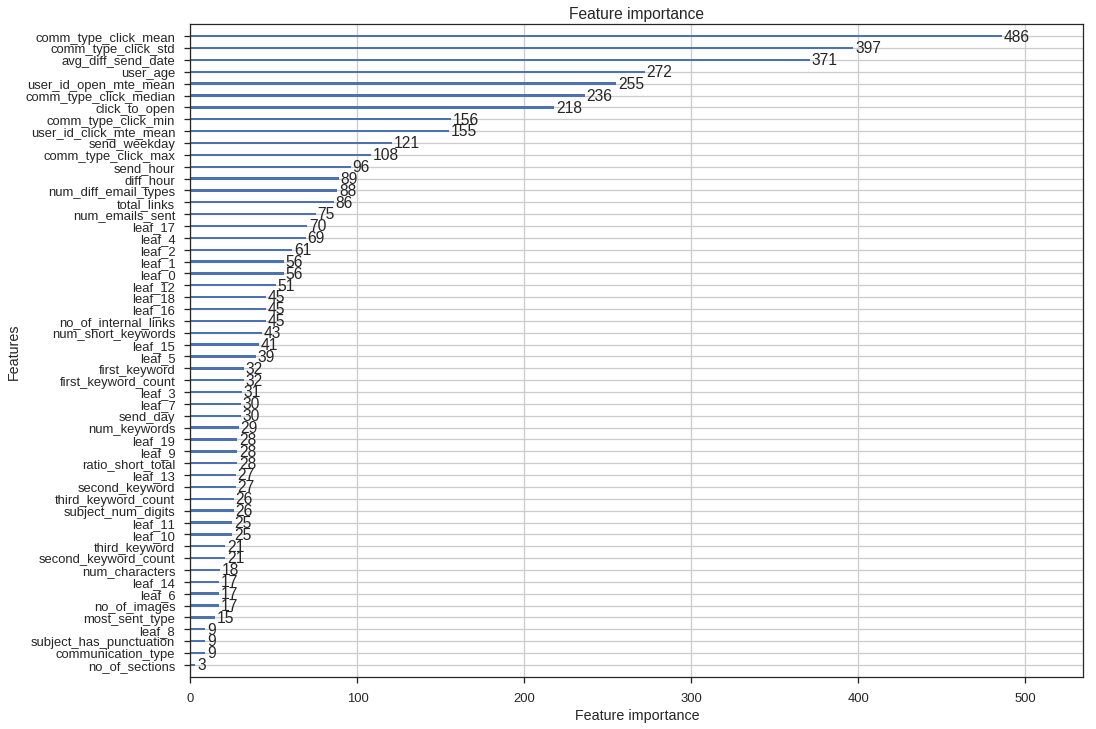

In [23]:
fig, ax = plt.subplots(1, figsize=(16, 12))
lgb.plot_importance(m, ax=ax);

## Full Training

In [23]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(147 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

## Submission

In [24]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission26.csv', index=False)